# Analytical Flow-Matching

# In Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

import torch
import torch.nn.functional as F
from torch import nn, Tensor

# Importing our existing flow funcs
import os
import sys
from pathlib import Path
# Add parent directory to sys.path
parent_dir = Path.cwd().parent.parent
sys.path.append(str(parent_dir))
# Import modules
from analytic_flow_funcs import compute_linear_velocity_batch, forward_euler_integration_analytic_linear, compute_linear_velocity_batch_time

# Distribution Generation

We generate and visualize our input and output distributions that we want to flow from.

For the analytical solution derived above, the input distribution must always be an n-dimensional independent Gaussian, but our output can be arbitrary.

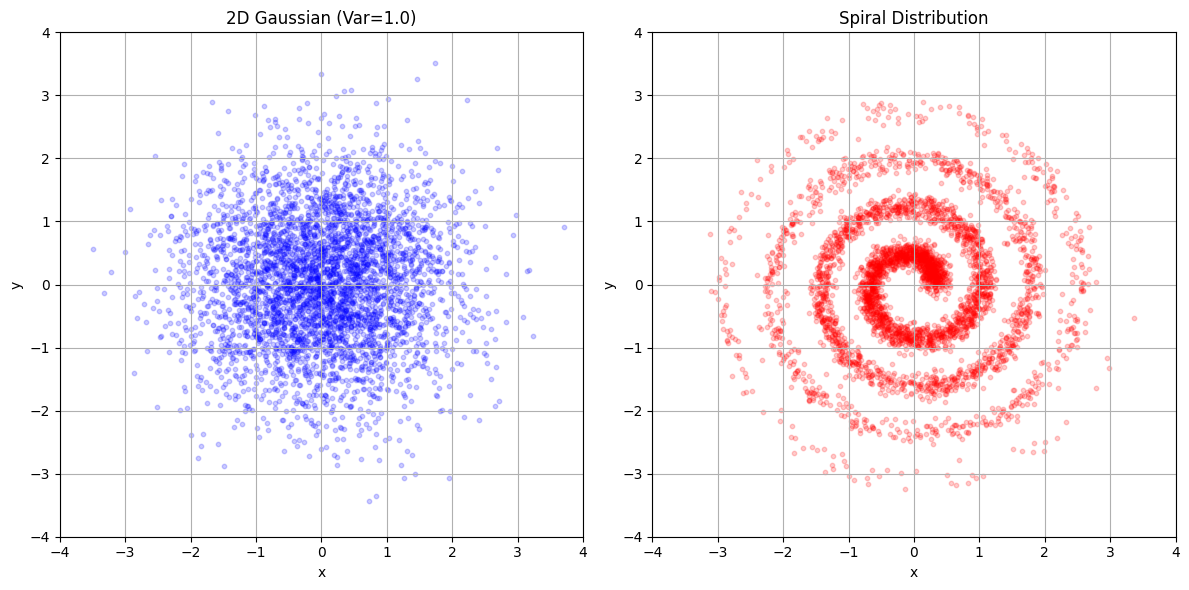

torch.Size([4000, 2])


In [2]:
def generate_gaussian(n_dims, num_points, noise_std=1.0):
    """
    Generate an n-dimensional independent Gaussian distribution with specified variance.
    """
    return torch.randn(num_points, n_dims) * (noise_std)

def generate_spiral(num_points, noise_std=0.1, n_turns=4, radius_scale=0.5):
    """
    Generate a 2D spiral distribution where points far along the spiral are less likely.
    
    Args:
        num_points: Number of points to generate
        noise_std: Standard deviation of Gaussian noise added to the spiral
        n_turns: Number of full rotations in the spiral (default: 4)
        radius_scale: Scaling factor for the spiral radius (default: 0.5)
        
    Returns:
        torch.Tensor of shape (num_points, 2)
    """
    max_angle = 2 * np.pi * n_turns
    t = torch.linspace(0, max_angle, num_points)
    # Make points further along the spiral less likely by scaling t with a random factor
    t = t * torch.pow(torch.rand(num_points), 0.5)
    
    # Spiral equation with adjustable radius
    r = radius_scale * (t / max_angle + 0.1)  # The +0.1 ensures the spiral doesn't start at 0
    x = r * torch.cos(t)
    y = r * torch.sin(t)
    
    # Add Gaussian noise
    x += torch.randn(num_points) * noise_std
    y += torch.randn(num_points) * noise_std
    return torch.stack([x, y], dim=1)

# Generate samples with different variances
sigma_i = 1.0
num_points = 4000
gaussian_samples1 = generate_gaussian(n_dims=2, num_points=num_points, noise_std=sigma_i)  # Default variance
spiral_samples = generate_spiral(num_points=num_points, noise_std = 0.1, n_turns = 4, radius_scale = 3)

# Initial and final distributions
initial_dist = gaussian_samples1
final_dist = spiral_samples

x_lim_params = (-4, 4)
y_lim_params = (-4, 4)

# Plot the distributions
plt.figure(figsize=(12, 6))

# Plot Gaussian distribution with variance=1.0
plt.subplot(1, 2, 1)
plt.scatter(initial_dist[:, 0].numpy(), initial_dist[:, 1].numpy(), 
            c='blue', alpha=0.2, s=10)
plt.title('2D Gaussian (Var=1.0)')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(x_lim_params)  
plt.ylim(y_lim_params)  
plt.grid(True)

# Plot Spiral distribution
plt.subplot(1, 2, 2)
plt.scatter(final_dist[:, 0].numpy(), final_dist[:, 1].numpy(), 
            c='red', alpha=0.2, s=10)
plt.title('Spiral Distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(x_lim_params)  
plt.ylim(y_lim_params)  
plt.grid(True)

plt.tight_layout()
plt.show()

print (final_dist.shape)

# Machine Learning Naive

Having demonstrated our exact solution, we now implement a machine learning solution to the flow-matching problem with a fully connected neural network.

## Training

In [3]:
# Define the Flow model
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.SiLU(),
            nn.Linear(h, h), nn.SiLU(),
            nn.Linear(h, h), nn.SiLU(),
            nn.Linear(h, h), nn.SiLU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))

# Set device at the beginning (once)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model and optimizer
flow = Flow().to(device)
optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
batch_size = 2048
n_epochs = 20000

initial_dist_ml = initial_dist.to(device)
final_dist_ml = final_dist.to(device)

# Create directory for saving models
os.makedirs('saved_models', exist_ok=True)

# Training loop with device awareness
start_time = time.time()
for epoch in range(n_epochs):
    # Random batch indices - created on target device directly
    idx_0 = torch.randperm(num_points, device=device)[:batch_size]  # Input indices
    idx_1 = torch.randperm(num_points, device=device)[:batch_size]  # Output indices
    
    x_0 = initial_dist_ml[idx_0]  # Random batch from input distribution
    x_1 = final_dist_ml[idx_1]  # Random batch from output distribution
    
    # Random time points - created on target device
    t = torch.rand(batch_size, 1, device=device)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    # Forward pass
    optimizer.zero_grad()
    pred = flow(t, x_t)  # Model is on device
    loss = loss_fn(pred, dx_t)
    loss.backward()
    optimizer.step()
    
    if epoch % 3000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        
        # Save model checkpoint
        checkpoint_path = f'saved_models/flow_model_epoch_{epoch}.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': flow.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }, checkpoint_path)
        print(f"Saved model checkpoint to {checkpoint_path}")

elapsed_time = time.time() - start_time
print(f"Training completed in {elapsed_time:.4f} seconds")

# Save final model
final_path = 'saved_models/flow_model_final.pt'
torch.save({
    'epoch': n_epochs,
    'model_state_dict': flow.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
}, final_path)
print(f"Saved final model to {final_path}")

Epoch 0, Loss: 2.0680
Saved model checkpoint to saved_models/flow_model_epoch_0.pt
Epoch 3000, Loss: 1.6489
Saved model checkpoint to saved_models/flow_model_epoch_3000.pt
Epoch 6000, Loss: 1.6510
Saved model checkpoint to saved_models/flow_model_epoch_6000.pt
Epoch 9000, Loss: 1.6271
Saved model checkpoint to saved_models/flow_model_epoch_9000.pt
Epoch 12000, Loss: 1.6795
Saved model checkpoint to saved_models/flow_model_epoch_12000.pt
Epoch 15000, Loss: 1.5590
Saved model checkpoint to saved_models/flow_model_epoch_15000.pt
Epoch 18000, Loss: 1.6150
Saved model checkpoint to saved_models/flow_model_epoch_18000.pt
Training completed in 67.0678 seconds
Saved final model to saved_models/flow_model_final.pt


## Visualization

In [4]:
def forward_euler_integration_model(
    initial_points: torch.Tensor,  # [m, d]
    flow_model: nn.Module,          # Trained Flow model
    t_start: float = 0.0,           # Typically 0
    t_end: float = 1.0,             # Typically 1
    num_steps: int = 100,           # Integration steps
    save_trajectory: bool = True    # Whether to store full trajectory
) -> torch.Tensor:

    dt = (t_end - t_start) / num_steps
    current_points = initial_points.clone()
    
    if save_trajectory:
        trajectory = torch.zeros(num_steps + 1, *initial_points.shape, 
                               device=initial_points.device)
        trajectory[0] = current_points.clone()
    
    current_time = t_start
    
    for step in range(1, num_steps + 1):
        # Compute velocity from learned model
        with torch.no_grad():  # Disable gradients for integration
            t_tensor = torch.full((current_points.shape[0], 1), current_time,
                                device=current_points.device)
            velocity = flow_model(t_tensor, current_points)
        
        # Euler update
        current_points = current_points + velocity * dt
        current_time = current_time + dt
        
        if save_trajectory:
            trajectory[step] = current_points.clone()
    
    return trajectory if save_trajectory else current_points

Processing epoch 0...
Processing epoch 3000...
Processing epoch 6000...
Processing epoch 9000...
Processing epoch 12000...
Processing epoch 15000...
Processing epoch 18000...
Processing epoch Final...


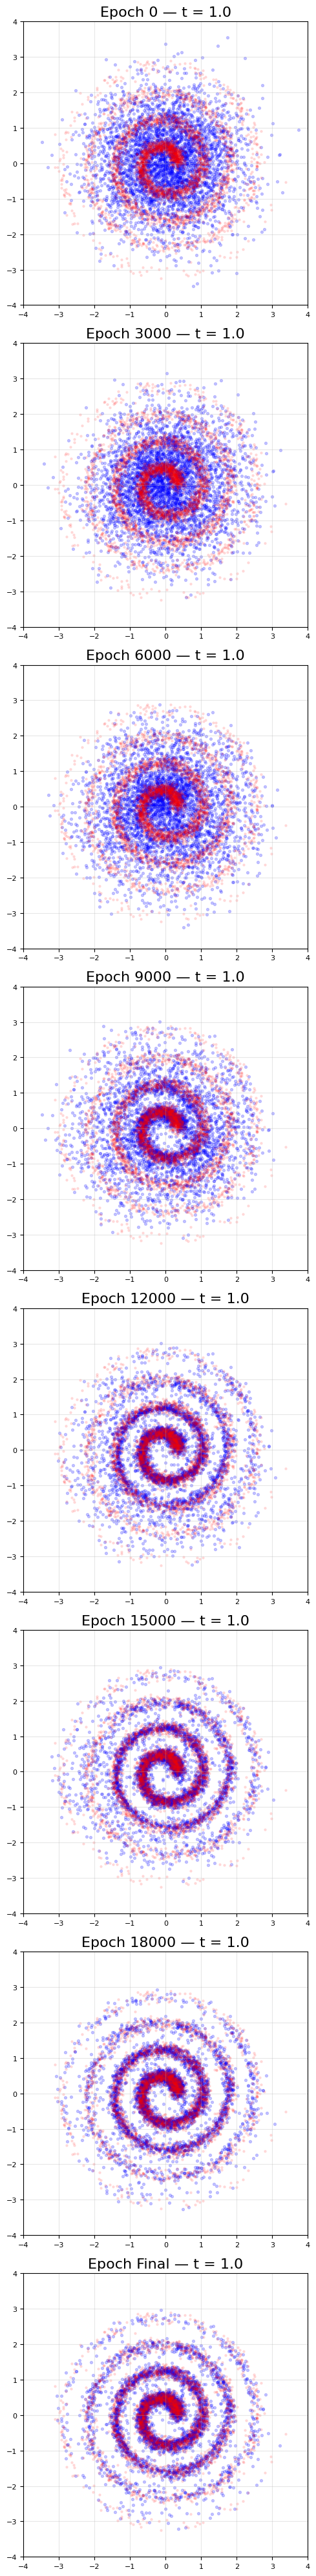

Saved combined_trajectories.png


In [5]:
import glob
import re

def create_combined_plot_many(all_trajectories, epoch_list, num_steps=100, filename = None):
    # Time points to display (0.25, 0.5, 0.75, 1.0)
    time_points = [0.25, 0.5, 0.75, 1.0]
    steps_to_plot = [int(t * num_steps) for t in time_points]
    
    # Create one tall figure with subplots
    n_epochs = len(epoch_list)
    fig, axes = plt.subplots(n_epochs, 4, figsize=(10, 2.5 * n_epochs))
    
    for row, (epoch, trajectory) in enumerate(zip(epoch_list, all_trajectories)):
        for col, step in enumerate(steps_to_plot):
            ax = axes[row, col] if n_epochs > 1 else axes[col]  # Handle single-row case
            current_points = trajectory[step]
            
            # Plot current points and target distribution
            ax.scatter(current_points[:, 0].cpu().numpy(), 
                      current_points[:, 1].cpu().numpy(),
                      c='blue', alpha=0.2, s=5, label='Flow')
            ax.scatter(final_dist[:, 0].numpy(), 
                      final_dist[:, 1].numpy(),
                      c='red', alpha=0.1, s=3, label='Target')
            
            # Only add titles to first row
            if row == 0:
                ax.set_title(f't = {time_points[col]:.2f}', fontsize=20)
            
            # Only add y-label to first column
            if col == 0:
                ax.set_ylabel(f'Epoch {epoch}', fontsize=20)
            else:
                ax.set_ylabel('')
                
            #ax.set_xlabel('X', fontsize=20)
            ax.set_xlim(x_lim_params)  
            ax.set_ylim(y_lim_params)  
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='both', which='major', labelsize=6)
    
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

def create_combined_plot(all_trajectories, epoch_list, num_steps=100, filename=None):
    """
    Plot only the final step (t=1.0) for each trajectory in all_trajectories.

    Parameters:
    - all_trajectories: List of trajectory tensors (each shape: [num_steps, batch_size, 2])
    - epoch_list: List of epoch numbers corresponding to each trajectory
    - num_steps: Number of steps per trajectory
    - filename: Optional filename to save the figure
    """
    final_step = num_steps - 1  # t = 1.0 is last step
    n_epochs = len(epoch_list)
    
    # Create vertical stack of plots
    fig, axes = plt.subplots(n_epochs, 1, figsize=(5, 5 * n_epochs))
    if n_epochs == 1:
        axes = [axes]  # Ensure iterable for single-row case

    for ax, epoch, trajectory in zip(axes, epoch_list, all_trajectories):
        current_points = trajectory[final_step]
        
        # Plot flow points
        ax.scatter(current_points[:, 0].cpu().numpy(),
                   current_points[:, 1].cpu().numpy(),
                   c='blue', alpha=0.2, s=8, label='Flow')

        # Plot target distribution
        ax.scatter(final_dist[:, 0].numpy(),
                   final_dist[:, 1].numpy(),
                   c='red', alpha=0.1, s=5, label='Target')

        ax.set_title(f'Epoch {epoch} — t = 1.0', fontsize=16)
        ax.set_xlim(x_lim_params)
        ax.set_ylim(y_lim_params)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=8)

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

# Get and sort model files by epoch
model_files = sorted(glob.glob('saved_models/flow_model_epoch_*.pt'), 
                    key=lambda x: int(re.search(r'epoch_(\d+)', x).group(1)))
model_files.append('saved_models/flow_model_final.pt')

# Store all trajectories and epochs
all_trajectories = []
epoch_list = []

for model_file in model_files:
    # Load model
    epoch = 'Final' if 'final' in model_file.lower() else re.search(r'epoch_(\d+)', model_file).group(1)
    print(f"Processing epoch {epoch}...")
    
    checkpoint = torch.load(model_file)
    flow = Flow().to(device)
    flow.load_state_dict(checkpoint['model_state_dict'])
    flow.eval()
    
    # Generate trajectory
    trajectory = forward_euler_integration_model(
        initial_points=initial_dist_ml,
        flow_model=flow,
        num_steps=100
    )
    
    all_trajectories.append(trajectory)
    epoch_list.append(epoch)

# Create combined plot
create_combined_plot(all_trajectories, epoch_list, filename = "combined_trajectories.png")
print("Saved combined_trajectories.png")

# Test Batched Time Code

We rewrite our functions to allow for arbitrary t values in a batch, instead of one fixed t.

In [6]:
t_value = np.random.rand()

# Run original version
original_vel = compute_linear_velocity_batch(
    current_points=initial_dist,
    data=final_dist,
    t=t_value,  # create tensor with same time for all
    sigma_i=sigma_i,
)

# Run batched version (with time as tensor)
batched_vel = compute_linear_velocity_batch_time(
    current_points=initial_dist,
    data=final_dist,
    t=torch.full((num_points,), t_value),  # create tensor with same time for all
    sigma_i=sigma_i,
)

print ("Time shape is ", torch.full((num_points,), t_value).shape)

# Compare results
print("Original velocities:\n", original_vel)
print("\nBatched velocities:\n", batched_vel)

# Check numerical equivalence
assert torch.allclose(original_vel, batched_vel, atol=1e-3), "Outputs differ!"
print("\nTest passed! Outputs match within 1e-3 tolerance")

Time shape is  torch.Size([4000])
Original velocities:
 tensor([[-0.0214, -0.7110],
        [-0.1048, -0.8534],
        [-0.6979,  0.9622],
        ...,
        [-0.9164, -0.4738],
        [-0.0113,  0.0321],
        [-1.5085,  0.5895]])

Batched velocities:
 tensor([[-0.0214, -0.7110],
        [-0.1048, -0.8534],
        [-0.6979,  0.9622],
        ...,
        [-0.9164, -0.4738],
        [-0.0113,  0.0321],
        [-1.5085,  0.5895]])

Test passed! Outputs match within 1e-3 tolerance


# Test Batched Time Code

We rewrite our functions to allow for arbitrary t values in a batch, instead of one fixed t.

In [7]:
# Set device at the beginning (once)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model and optimizer
flow = Flow().to(device)
optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
batch_size = 2048
n_epochs = 20000

initial_dist_ml = initial_dist.to(device)
final_dist_ml = final_dist.to(device)

# Create directory for saving models
os.makedirs('saved_smartly_trained_models', exist_ok=True)

# Training loop with device awareness
start_time = time.time()
for epoch in range(n_epochs):
    # Random batch indices - created on target device directly
    idx_0 = torch.randperm(num_points, device=device)[:batch_size]  # Input indices
    idx_1 = torch.randperm(num_points, device=device)[:batch_size]  # Output indices
    
    x_0 = initial_dist_ml[idx_0]  # Random batch from input distribution
    x_1 = final_dist_ml[idx_1]  # Random batch from output distribution
    
    # Random time points - created on target device
    t = torch.rand(batch_size, 1, device=device)
    
    x_t = (1 - t) * x_0 + t * x_1
    t_compute_batch = t.view(-1) 
    #print ("Time shape is ", t_compute_batch.shape)
    #print (x_t.shape)
    dx_t = compute_linear_velocity_batch_time(x_t, final_dist_ml, t_compute_batch, sigma_i)
    
    # Forward pass
    optimizer.zero_grad()
    pred = flow(t, x_t)  # Model is on device
    loss = loss_fn(pred, dx_t)
    loss.backward()
    optimizer.step()
    
    if epoch % 3000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        
        # Save model checkpoint
        checkpoint_path = f'saved_smartly_trained_models/flow_model_epoch_{epoch}.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': flow.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }, checkpoint_path)
        print(f"Saved model checkpoint to {checkpoint_path}")

elapsed_time = time.time() - start_time
print(f"Training completed in {elapsed_time:.4f} seconds")

# Save final model
final_path = 'saved_smartly_trained_models/flow_model_final.pt'
torch.save({
    'epoch': n_epochs,
    'model_state_dict': flow.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
}, final_path)
print(f"Saved final model to {final_path}")

Epoch 0, Loss: 0.5089
Saved model checkpoint to saved_smartly_trained_models/flow_model_epoch_0.pt
Epoch 3000, Loss: 0.0614
Saved model checkpoint to saved_smartly_trained_models/flow_model_epoch_3000.pt
Epoch 6000, Loss: 0.0413
Saved model checkpoint to saved_smartly_trained_models/flow_model_epoch_6000.pt
Epoch 9000, Loss: 0.0224
Saved model checkpoint to saved_smartly_trained_models/flow_model_epoch_9000.pt
Epoch 12000, Loss: 0.0232
Saved model checkpoint to saved_smartly_trained_models/flow_model_epoch_12000.pt
Epoch 15000, Loss: 0.0226
Saved model checkpoint to saved_smartly_trained_models/flow_model_epoch_15000.pt
Epoch 18000, Loss: 0.0283
Saved model checkpoint to saved_smartly_trained_models/flow_model_epoch_18000.pt
Training completed in 76.0492 seconds
Saved final model to saved_smartly_trained_models/flow_model_final.pt


Processing epoch 0...
Processing epoch 3000...
Processing epoch 6000...
Processing epoch 9000...
Processing epoch 12000...
Processing epoch 15000...
Processing epoch 18000...
Processing epoch Final...


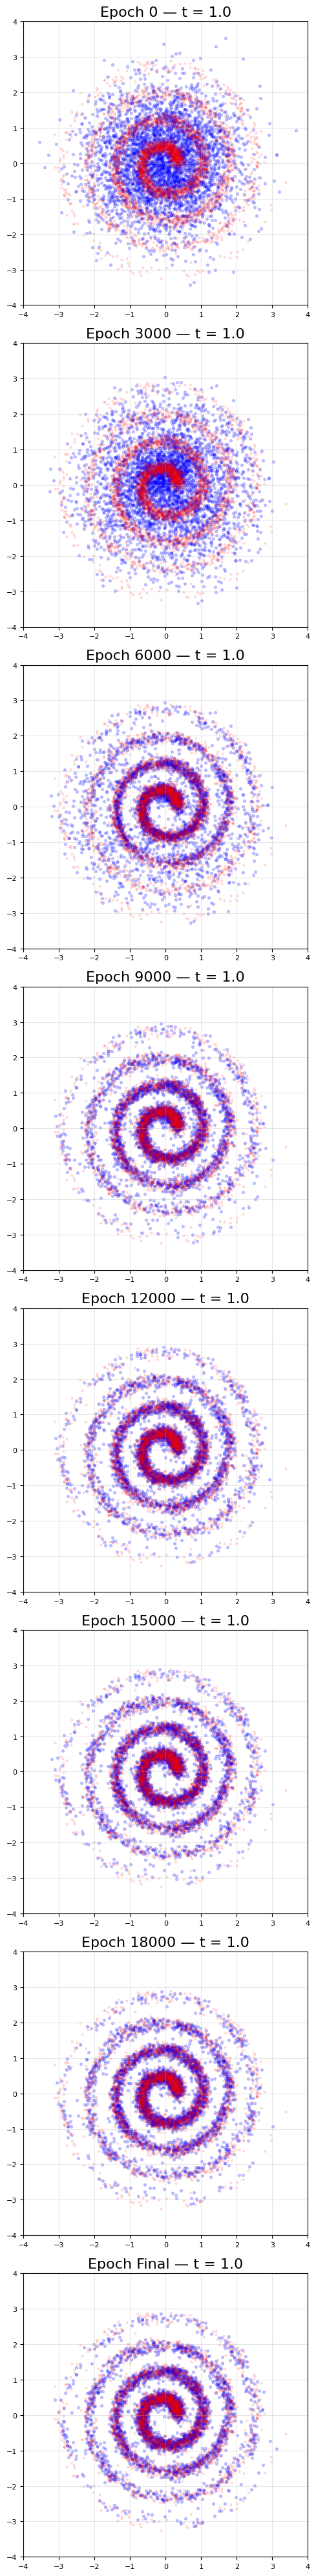

Saved smart_combined_trajectories.png


In [8]:
# Get and sort model files by epoch
model_files = sorted(glob.glob('saved_smartly_trained_models/flow_model_epoch_*.pt'), 
                    key=lambda x: int(re.search(r'epoch_(\d+)', x).group(1)))
model_files.append('saved_smartly_trained_models/flow_model_final.pt')

# Store all trajectories and epochs
all_trajectories = []
epoch_list = []

for model_file in model_files:
    # Load model
    epoch = 'Final' if 'final' in model_file.lower() else re.search(r'epoch_(\d+)', model_file).group(1)
    print(f"Processing epoch {epoch}...")
    
    checkpoint = torch.load(model_file)
    flow = Flow().to(device)
    flow.load_state_dict(checkpoint['model_state_dict'])
    flow.eval()
    
    # Generate trajectory
    trajectory = forward_euler_integration_model(
        initial_points=initial_dist_ml,
        flow_model=flow,
        num_steps=100
    )
    
    all_trajectories.append(trajectory)
    epoch_list.append(epoch)

# Create combined plot
create_combined_plot(all_trajectories, epoch_list, filename = "smart_combined_trajectories.png")
print("Saved smart_combined_trajectories.png")